In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder


In [2]:
class Conv2D:
    def __init__(self, num_filters, filter_size, padding=0, stride=1):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        self.filters = np.random.randn(num_filters, filter_size, filter_size) * 0.1
    
    def iterate_regions(self, image):
        h, w = image.shape
        
        for i in range(0, h - self.filter_size + 1, self.stride):
            for j in range(0, w - self.filter_size + 1, self.stride):
                im_region = image[i:(i + self.filter_size), j:(j + self.filter_size)]
                yield im_region, i, j
    
    def forward(self, input):
        self.last_input = input
        h, w = input.shape
        
        # Calculate output dimensions
        output_h = (h - self.filter_size + 2 * self.padding) // self.stride + 1
        output_w = (w - self.filter_size + 2 * self.padding) // self.stride + 1
        
        output = np.zeros((self.num_filters, output_h, output_w))
        
        for im_region, i, j in self.iterate_regions(input):
            output[:, i//self.stride, j//self.stride] = np.sum(
                im_region * self.filters, axis=(1, 2))
        
        return output
    
    def backward(self, d_L_d_out, learning_rate):
        d_L_d_filters = np.zeros(self.filters.shape)
        
        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[f, i//self.stride, j//self.stride] * im_region
        
        self.filters -= learning_rate * d_L_d_filters
        return None


In [3]:
class MaxPool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride
    
    def iterate_regions(self, image):
        h, w, _ = image.shape
        new_h = h // self.pool_size
        new_w = w // self.pool_size
        
        for i in range(new_h):
            for j in range(new_w):
                im_region = image[
                    (i * self.stride):(i * self.stride + self.pool_size),
                    (j * self.stride):(j * self.stride + self.pool_size)]
                yield im_region, i, j
    
    def forward(self, input):
        self.last_input = input
        h, w, num_filters = input.shape
        output = np.zeros((h // self.pool_size, w // self.pool_size, num_filters))
        
        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))
        
        return output
    
    def backward(self, d_L_d_out):
        d_L_d_input = np.zeros(self.last_input.shape)
        
        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))
            
            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[
                                i * self.stride + i2,
                                j * self.stride + j2,
                                f2] = d_L_d_out[i, j, f2]
        
        return d_L_d_input


In [4]:
class Flatten:
    def forward(self, input):
        self.last_input_shape = input.shape
        return input.flatten()
    
    def backward(self, d_L_d_out):
        return d_L_d_out.reshape(self.last_input_shape)


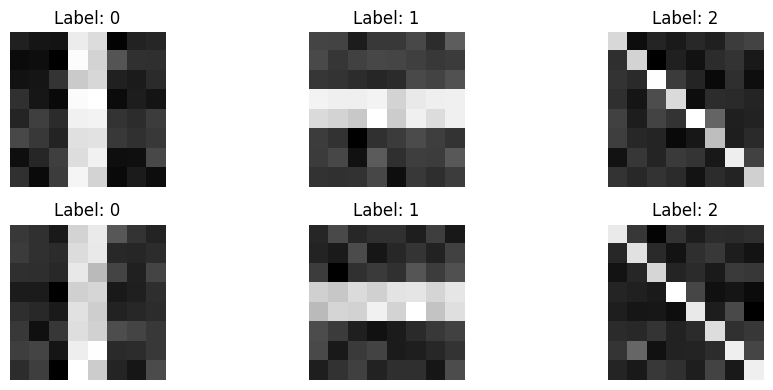

In [5]:
class CNN:
    def __init__(self):
        self.conv = Conv2D(num_filters=8, filter_size=3)
        self.pool = MaxPool2D(pool_size=2, stride=2)
        self.flatten = Flatten()
        
        # FC layer weights (for 28x28 images -> pool -> 13x13 -> flatten -> 1352)
        self.weights_fc = np.random.randn(1352, 10) * 0.1
        self.biases_fc = np.zeros(10)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum()
    
    def cross_entropy_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        return loss
    
    def forward(self, image, label):
        # Reshape if needed
        if len(image.shape) == 2:
            image = image.reshape(28, 28)
        
        # Forward pass through layers
        out = self.conv.forward(image)
        out = self.pool.forward(out)
        out = self.flatten.forward(out)
        
        # Fully connected layer
        out = np.dot(out, self.weights_fc) + self.biases_fc
        out = self.softmax(out)
        
        # Calculate loss
        loss = self.cross_entropy_loss(out, label)
        
        return out, loss
    
    def train(self, train_images, train_labels, epochs=10, learning_rate=0.01):
        losses = []
        
        for epoch in range(epochs):
            loss = 0
            correct = 0
            
            for i, (image, label) in enumerate(zip(train_images, train_labels)):
                # Forward pass
                output, l = self.forward(image, label)
                loss += l
                
                # Calculate accuracy
                if np.argmax(output) == np.argmax(label):
                    correct += 1
                
                # Backward pass (simplified)
                # Note: Full backpropagation would be more complex
                error = output - label
                
                # This is a simplified training - full implementation would require
                # proper backprop through all layers
            
            accuracy = correct / len(train_images)
            avg_loss = loss / len(train_images)
            losses.append(avg_loss)
            
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return losses

def create_toy_cnn_dataset():
    # Create simple 8x8 images
    num_samples = 100
    images = []
    labels = []
    
    for i in range(num_samples):
        # Create simple patterns
        img = np.zeros((8, 8))
        
        if i % 3 == 0:
            # Vertical line
            img[:, 3:5] = 1
            label = 0
        elif i % 3 == 1:
            # Horizontal line
            img[3:5, :] = 1
            label = 1
        else:
            # Diagonal
            np.fill_diagonal(img, 1)
            label = 2
        
        images.append(img + np.random.normal(0, 0.1, (8, 8)))
        labels.append(label)
    
    # One-hot encode labels
    enc = OneHotEncoder(sparse_output=False)
    labels_onehot = enc.fit_transform(np.array(labels).reshape(-1, 1))
    
    return np.array(images), labels_onehot

if __name__ == "__main__":
    # Create toy dataset
    images, labels = create_toy_cnn_dataset()
    
    # Create and train CNN
    cnn = CNN()
    
    # Note: This is a simplified CNN. For full training, we'd need
    # to implement complete backpropagation
    
    # Visualize some samples
    plt.figure(figsize=(10, 4))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {np.argmax(labels[i])}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('cnn_samples.png')
    plt.show()